# SPY Model
#### This notebook includes three models of the daily close of the S&P 500 ETF ticker: SPY.
#### The first is a Linear Regression, or OLS that regresses the daily close value of the spread between the 3-Month 10-Year U.S. Treasuries, as well as the daily close prices of the K.B.W. Bank Index, ticker: BKX, the EUR/USD currency pair, the USD/JPY currency pair, the Volatility Index, ticker: VIX, and West Texas Intermediate oil, or WTI, on the daily close price of the SPY.
#### The second model is a Principal Component Regression, or PCR of the same features as the linear regression. Principal Component Analysis can help reduce colinearity between features. And, that is, certainly the case with this feature set. The first two components were chosen as the regressors.
#### The final model is a Seasonal Autoregressive Integrated Moving Average model with Exonegous Regressors, or SARIMAX. This model is useful for time series data, and attempts to remove patterns that might exist.



# SET UP WORKSPACE

In [1]:
# Import Libraries
import numpy as np                                           # For linear algebra
import pandas as pd                                          # For data manipulation
import math                                                  # For math functions
import matplotlib.pyplot as plt                              # For plotting
import matplotlib.ticker as ticker                           # For tick spacing
from pandas.plotting import autocorrelation_plot             # For autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf           # For autocorrelation function plot
from statsmodels.graphics.tsaplots import plot_pacf          # For partial autocorrelation function plot
from pandas.plotting import lag_plot                         # For lag plot
from sklearn.decomposition import PCA                        # For PCA
from sklearn.linear_model import LinearRegression            # For regressions
from sklearn.model_selection import TimeSeriesSplit          # For test/train splits
import statsmodels.api as sm                                 # For SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # For seasonal/cyclical decomposition
import itertools                                             # For grid search
from IPython.display import Image                            # For displaying images
import warnings                                              # For warning suppression

#### NOTE: If the total_df has been built and cleaned, skip to DATA EXPLORATION, and load the local csv. Otherwise, continue to DATA PREP.

# DATA PREP
## Build the data set

In [2]:
# Load data
spy = pd.read_csv('assets/SPY.csv')
ust = pd.read_csv('assets/3-10UST.csv')
bkx = pd.read_csv('assets/^BKX.csv')
eur = pd.read_csv('assets/EURUSD=X.csv')
jpy = pd.read_csv('assets/JPY=X.csv')
vix = pd.read_csv('assets/^VIX.csv')
wti = pd.read_csv('assets/WTI.csv')

In [3]:
# Take a look at the SPY data
spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,92.788483,118944600
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,93.034081,111579900
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,93.099579,116074400
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,93.492622,131091100
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,93.803726,126402800


#### The SPY data include columns that are not needed. Drop all but the close and date columns.

In [4]:
# Drop columns
spy_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
spy = spy.drop(spy_cols, axis=1)

# Change column name
spy.rename(columns={'Close':'spy'}, inplace=True)

# Print columns
spy.columns

Index(['Date', 'spy'], dtype='object')

In [5]:
# Take a look at the 10 year 3 month US Treasury spread data
ust.head()

,DATE,T10Y3M
0,2010-01-04,3.77
1,2010-01-05,3.70
2,2010-01-06,3.79
3,2010-01-07,3.80
4,2010-01-08,3.78


In [6]:
# Change column name
ust.rename(columns={'T10Y3M':'ust'}, inplace=True)

# Print columns
ust.columns

Index(['DATE', 'ust'], dtype='object')

#### The US Treasury data above looks good for the moment.

In [7]:
# Take a look at the BKX data
bkx.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,42.709999,43.770000,42.709999,43.68,43.68,1.385209e+10
1,2010-01-05,43.680000,44.720001,43.639999,44.66,44.66,1.921731e+10
2,2010-01-06,44.660000,45.380001,44.389999,45.23,45.23,1.725584e+10
3,2010-01-07,45.230000,47.470001,45.130001,47.09,47.09,2.426611e+10
4,2010-01-08,47.070000,47.299999,46.509998,47.00,47.00,1.657134e+10


#### The BKX data include columns that are not needed. Drop all but the close and date columns.

In [8]:
# Drop columns
bkx_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
bkx = bkx.drop(bkx_cols, axis=1)

# Change column name
bkx.rename(columns={'Close':'bkx'}, inplace=True)

# Print columns
bkx.columns

Index(['Date', 'bkx'], dtype='object')

In [9]:
# Take a look at the EUR/USD
eur.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-01,1.432706,1.440196,1.432706,1.438994,1.438994,0.0
1,2010-01-04,1.431004,1.445191,1.426208,1.442398,1.442398,0.0
2,2010-01-05,1.442710,1.448310,1.435194,1.436596,1.436596,0.0
3,2010-01-06,1.436596,1.443460,1.429123,1.440403,1.440403,0.0
4,2010-01-07,1.440300,1.444481,1.430206,1.431803,1.431803,0.0


#### The EUR/USD data include columns that are not needed. Drop all but the close and date columns.

In [10]:
# Drop columns
eur_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
eur = eur.drop(eur_cols, axis=1)

# Change column name
eur.rename(columns={'Close':'eur'}, inplace=True)

# Print columns
eur.columns

Index(['Date', 'eur'], dtype='object')

In [11]:
# Take a look at the USD/JPY data
jpy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-01,92.940002,93.089996,92.919998,92.919998,92.919998,0.0
1,2010-01-04,92.760002,93.200996,92.196999,92.495003,92.495003,0.0
2,2010-01-05,92.470001,92.486000,91.282997,91.584999,91.584999,0.0
3,2010-01-06,91.550003,92.709999,91.522003,92.356003,92.356003,0.0
4,2010-01-07,92.335999,93.735001,92.110001,93.389999,93.389999,0.0


#### The USD/JPY data include columns that are not needed. Drop all but the close and date columns.

In [12]:
# Drop columns
jpy_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
jpy = jpy.drop(jpy_cols, axis=1)

# Change column name
jpy.rename(columns={'Close':'jpy'}, inplace=True)

# Print columns
jpy.columns

Index(['Date', 'jpy'], dtype='object')

In [13]:
# Take a look at the VIX data
vix.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,21.680000,21.680000,20.030001,20.040001,20.040001,0
1,2010-01-05,20.049999,20.129999,19.340000,19.350000,19.350000,0
2,2010-01-06,19.590000,19.680000,18.770000,19.160000,19.160000,0
3,2010-01-07,19.680000,19.709999,18.700001,19.059999,19.059999,0
4,2010-01-08,19.270000,19.270000,18.110001,18.129999,18.129999,0


#### The VIX data include columns that are not needed. Drop all but the close and date columns.

In [14]:
# Drop columns
vix_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
vix = vix.drop(vix_cols, axis=1)

# Change column name
vix.rename(columns={'Close':'vix'}, inplace=True)

# Print columns
vix.columns

Index(['Date', 'vix'], dtype='object')

In [15]:
# Take a look at the WTI data
wti.head()

,DATE,DCOILWTICO
0,2010-01-04,81.52
1,2010-01-05,81.74
2,2010-01-06,83.12
3,2010-01-07,82.60
4,2010-01-08,82.74


In [16]:
# Change column name
wti.rename(columns={'DCOILWTICO':'wti'}, inplace=True)

# Print columns
wti.columns

Index(['DATE', 'wti'], dtype='object')

#### The WTI data above looks good for the moment. We want to make sure that the dates align between the dependent and independent variables. Let's start by taking a look at the number of observations for each variable.

In [17]:
# Print the length of each variable
print('SPY obs: ', len(spy[:]))
print('UST obs: ', len(ust[:]))
print('BKX obs: ', len(bkx[:]))
print('EUR obs: ', len(eur[:]))
print('JPY obs: ', len(jpy[:]))
print('VIX obs: ', len(vix[:]))
print('WTI obs: ', len(wti[:]))

SPY obs:  2515
UST obs:  2607
BKX obs:  2515
EUR obs:  2608
JPY obs:  2608
VIX obs:  2515
WTI obs:  2607


#### We can see that the number of observations is not the same for each data set. It looks like the equity market data have 2,515 observations each, the currency data have 2,608 observations, and treasury and commodity data have 2,607. The data will need to be limited to observations from days that the SPY traded. Below, we drop any observations that were made on dates that are not included in the SPY data.

In [18]:
# Drop rows that do not match the SPY date data for each data set.
bkx = bkx[bkx.Date.isin(spy.Date)]
ust = ust[ust.DATE.isin(spy.Date)]
eur = eur[eur.Date.isin(spy.Date)]
jpy = jpy[jpy.Date.isin(spy.Date)]
wti = wti[wti.DATE.isin(spy.Date)]
vix = vix[vix.Date.isin(spy.Date)]

# Print the length of each variable
print('SPY obs: ', len(spy[:]))
print('UST obs: ', len(ust[:]))
print('BKX obs: ', len(bkx[:]))
print('EUR obs: ', len(eur[:]))
print('JPY obs: ', len(jpy[:]))
print('VIX obs: ', len(vix[:]))
print('WTI obs: ', len(wti[:]))

SPY obs:  2515
UST obs:  2515
BKX obs:  2515
EUR obs:  2515
JPY obs:  2515
VIX obs:  2515
WTI obs:  2515


In [19]:
# Create one dataframe 
total_df = pd.DataFrame(pd.concat([spy, ust['ust']], axis=1))
total_df = pd.concat([total_df, bkx['bkx'], eur['eur'],
                      jpy['jpy'], vix['vix'], wti['wti']],
                      axis=1)

# Change name of Date column to date
total_df.rename(columns={'Date':'date'}, inplace=True)

# Print columns
total_df.columns

Index(['date', 'spy', 'ust', 'bkx', 'eur', 'jpy', 'vix', 'wti'], dtype='object')

In [20]:
# Check class types
total_df.dtypes

date     object
spy     float64
ust      object
bkx     float64
eur     float64
jpy     float64
vix     float64
wti      object
dtype: object

#### The UST and WTI data are objects. Let's change all columns to numeric type. While we are at it, let's drop all but to places to the right of the decimal.

In [21]:
# Convert ust and wti column data to numeric type
total_df['ust'] = pd.to_numeric(total_df['ust'], errors='coerce')
total_df['bkx'] = pd.to_numeric(total_df['bkx'], errors='coerce')
total_df['eur'] = pd.to_numeric(total_df['eur'], errors='coerce')
total_df['jpy'] = pd.to_numeric(total_df['jpy'], errors='coerce')
total_df['vix'] = pd.to_numeric(total_df['vix'], errors='coerce')
total_df['wti'] = pd.to_numeric(total_df['wti'], errors='coerce')

# Drop decimals
total_df = total_df.round(decimals=2)

# Take a look
total_df.head()

,date,spy,ust,bkx,eur,jpy,vix,wti
0,2010-01-04,113.33,3.77,43.68,NaN,NaN,20.04,81.52
1,2010-01-05,113.63,3.70,44.66,1.44,92.50,19.35,81.74
2,2010-01-06,113.71,3.79,45.23,1.44,91.58,19.16,83.12
3,2010-01-07,114.19,3.80,47.09,1.44,92.36,19.06,82.60
4,2010-01-08,114.57,3.78,47.00,1.43,93.39,18.13,82.74


In [22]:
# Check for missing values and NA's
print('Number of missing values: ', total_df.isnull().values.any())
print('Number of NAs: ', total_df.isna().values.any())

Number of missing values:  True
Number of NAs:  True


In [23]:
# Locate columns with NA's
total_df.iloc[0]

date    2010-01-04
spy         113.33
ust           3.77
bkx          43.68
eur            NaN
jpy            NaN
vix          20.04
wti          81.52
Name: 0, dtype: object

#### From the print out above, we can see that the NAs are in the forex data. Let's drop those now.

In [24]:
# Drop NA's
raw_data_count = len(total_df)
total_df = total_df.dropna()
clean_data_count = len(total_df)

# Print number of rows dropped
print(raw_data_count - clean_data_count)

296


#### 296 observations were dropped.

In [25]:
# Check for missing values and NA's again
print('Number of missing values: ', total_df.isnull().values.any())
print('Number of NAs: ', total_df.isna().values.any())# Save date column as index

Number of missing values:  False
Number of NAs:  False


#### Let's save the data frame below.

In [26]:
# Save clean dataframe
total_df.to_csv('assets/total.csv', index=False)

# DATA EXPLORATION

In [2]:
# Load total_df
total_df = pd.read_csv('assets/total.csv')

In [3]:
# Save date column as index
total_df.set_index('date', inplace=True)

In [4]:
# Take a peek at the dataset
total_df.head()

,spy,ust,bkx,eur,jpy,vix,wti
date,,,,,,,
2010-01-05,113.63,3.70,44.66,1.44,92.50,19.35,81.74
2010-01-06,113.71,3.79,45.23,1.44,91.58,19.16,83.12
2010-01-07,114.19,3.80,47.09,1.44,92.36,19.06,82.60
2010-01-08,114.57,3.78,47.00,1.43,93.39,18.13,82.74
2010-01-11,114.73,3.81,47.03,1.44,92.66,17.55,82.54


In [5]:
# Take a peek at the dataset
total_df.tail()

,spy,ust,bkx,eur,jpy,vix,wti
date,,,,,,,
2019-12-23,321.22,-0.34,113.09,1.11,106.08,12.61,56.24
2019-12-24,321.23,-0.39,113.25,1.11,106.43,12.67,56.18
2019-12-26,322.94,-0.38,113.94,1.11,106.57,12.65,55.65
2019-12-27,322.86,-0.38,113.52,1.11,106.27,13.43,55.33
2019-12-30,321.08,-0.45,113.09,1.11,106.60,14.82,54.08


In [6]:
# Dimensions of data
total_df.shape

(2311, 7)

#### There are 6 explanatory variables and 2,331 observations. The date column is now the index of the dataframe.

In [7]:
# Descriptive statistics
total_df.describe()

,spy,ust,bkx,eur,jpy,vix,wti
count,2311.000000,2311.000000,2311.000000,2311.000000,2311.000000,2311.000000,2311.000000
mean,196.048174,1.894963,71.796158,1.236067,100.907997,16.907317,73.085045
std,58.710855,0.871040,21.849671,0.112782,14.224041,5.685977,22.086880
min,102.200000,-0.450000,33.650000,1.040000,75.740000,9.140000,26.190000
25%,137.870000,1.305000,51.320000,1.130000,86.475000,13.040000,51.890000
50%,198.200000,1.920000,69.700000,1.240000,103.700000,15.500000,73.970000
75%,243.170000,2.510000,92.930000,1.340000,111.865000,18.950000,93.850000
max,322.940000,3.810000,116.520000,1.480000,125.630000,48.000000,113.390000


#### There is large range of values. The target vector containing the SPY data ranges from 102.2 to 322.94. It is likely that the lessor values are older than the greater values. The mean of the SPY is 196.11, and it has a standard deviation of 58.72. The UST data is the only data that contain negative values which are a commonly used indicator for recession. It has a min of -0.45 and a max of 3.81. BKX data range from 33.65 to 116.52. The EUR data range from 1.04 to 1.48. The JPY data range from 75.74 to 125.63. The VIX data range from 9.14 to 48.00. The WTI data range from 26.19 to 113.39. The differences in ranges are not enormous, but maybe the data set could use some scaling.

#### Above, we can see that we dropped 8 rows of data that contained NA's

Text(0, 0.5, 'USD')

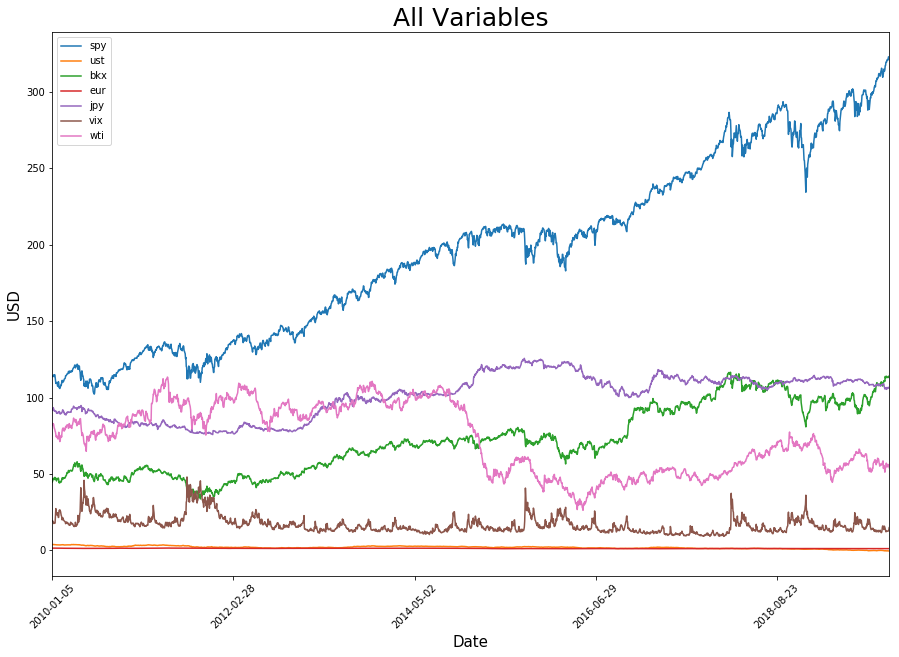

In [8]:
# Line charts
total_df.plot(figsize=(15,10))
plt.title('All Variables', size=25)
plt.xlabel('Date', size=15)
plt.xticks(rotation=45)
plt.ylabel('USD', size=15)

#### From the line chart above, it appears that some scaling could be helpful. The 3 Month - 10 Year US Treasury spread is shown in orange, and the EUR/USD cross in in red. Neither data set is displayed very well in this chart given the magnitudes of the other data -- especially the SPY price. Let's break them out below.

Text(0, 0.5, 'USD')

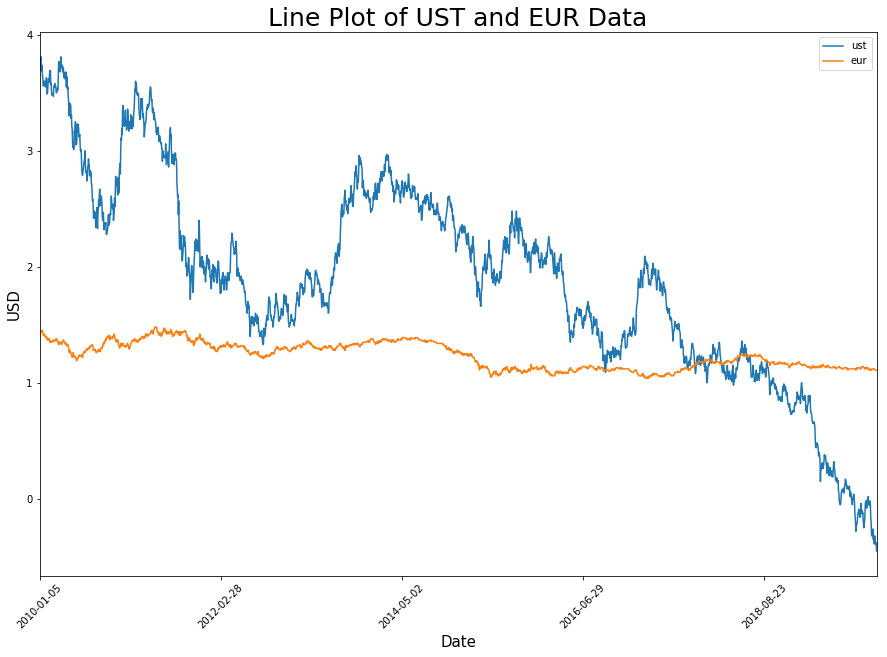

In [9]:
# Line charts of UST and EUR data

# Create dataframe containing both features
ust_eur = pd.DataFrame(pd.concat([total_df['ust'], total_df['eur']], axis=1))

# Plot
ust_eur.plot(figsize=(15,10))
plt.title('Line Plot of UST and EUR Data', size=25)
plt.xticks(rotation=45)
plt.xlabel('Date', size=15)
plt.ylabel('USD', size=15)

Text(0.5, 1.0, 'Histograms of All Features')

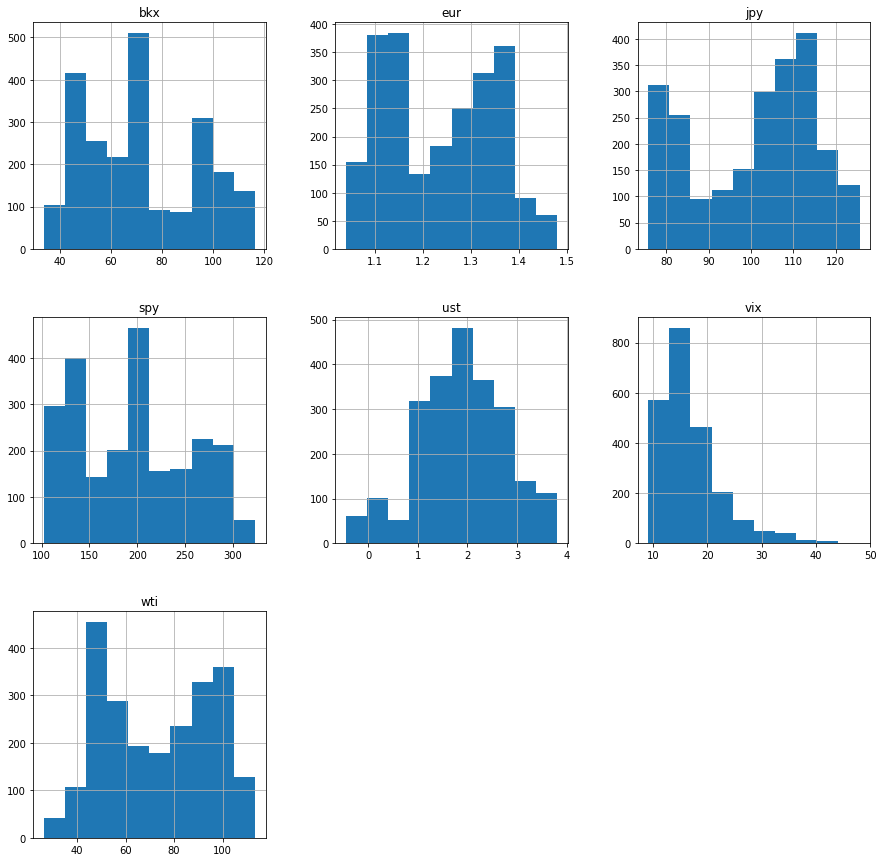

In [10]:
# Histograms
total_df.hist(figsize=(15,15))
plt.title('Histograms of All Features')

Text(0, 0.5, 'USD')

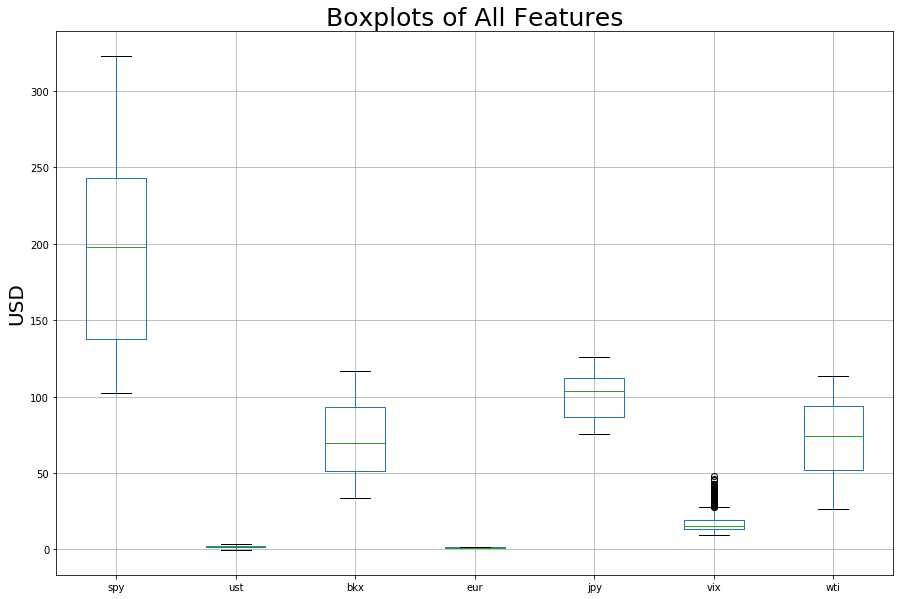

In [15]:
# Boxplots
total_df.boxplot(figsize=(15,10))
plt.title('Boxplots of All Features', size=25)
plt.ylabel('USD', size=20)

#### Again, we can see the different scales above just like with the previous line charts. Let's break the UST and EUR data below.

Text(0, 0.5, 'USD')

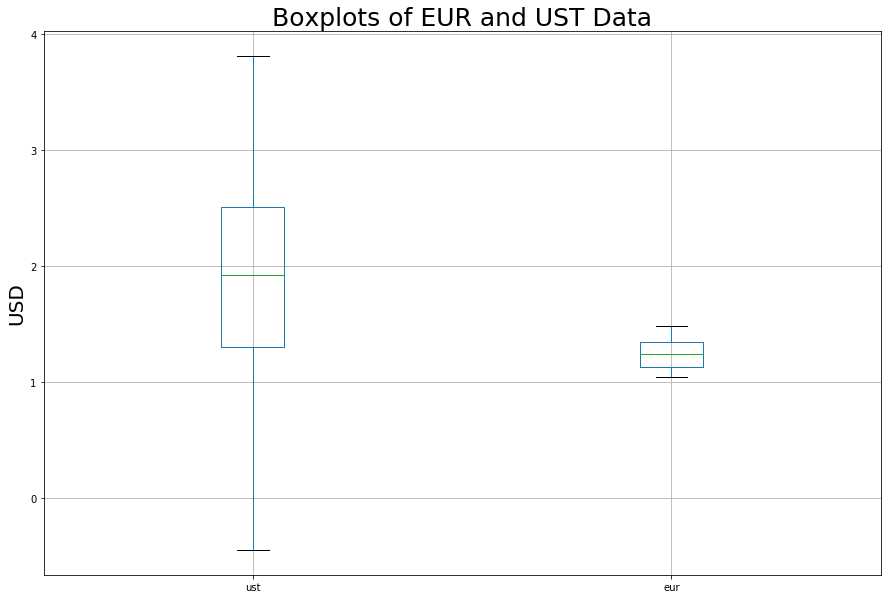

In [14]:
# Boxplots or UST and EUR data
ust_eur.boxplot(figsize=(15,10))
plt.title('Boxplots of EUR and UST Data', size=25)
plt.ylabel('USD', size=20)

#### Above, the range of the UST data can very clearly be seen.

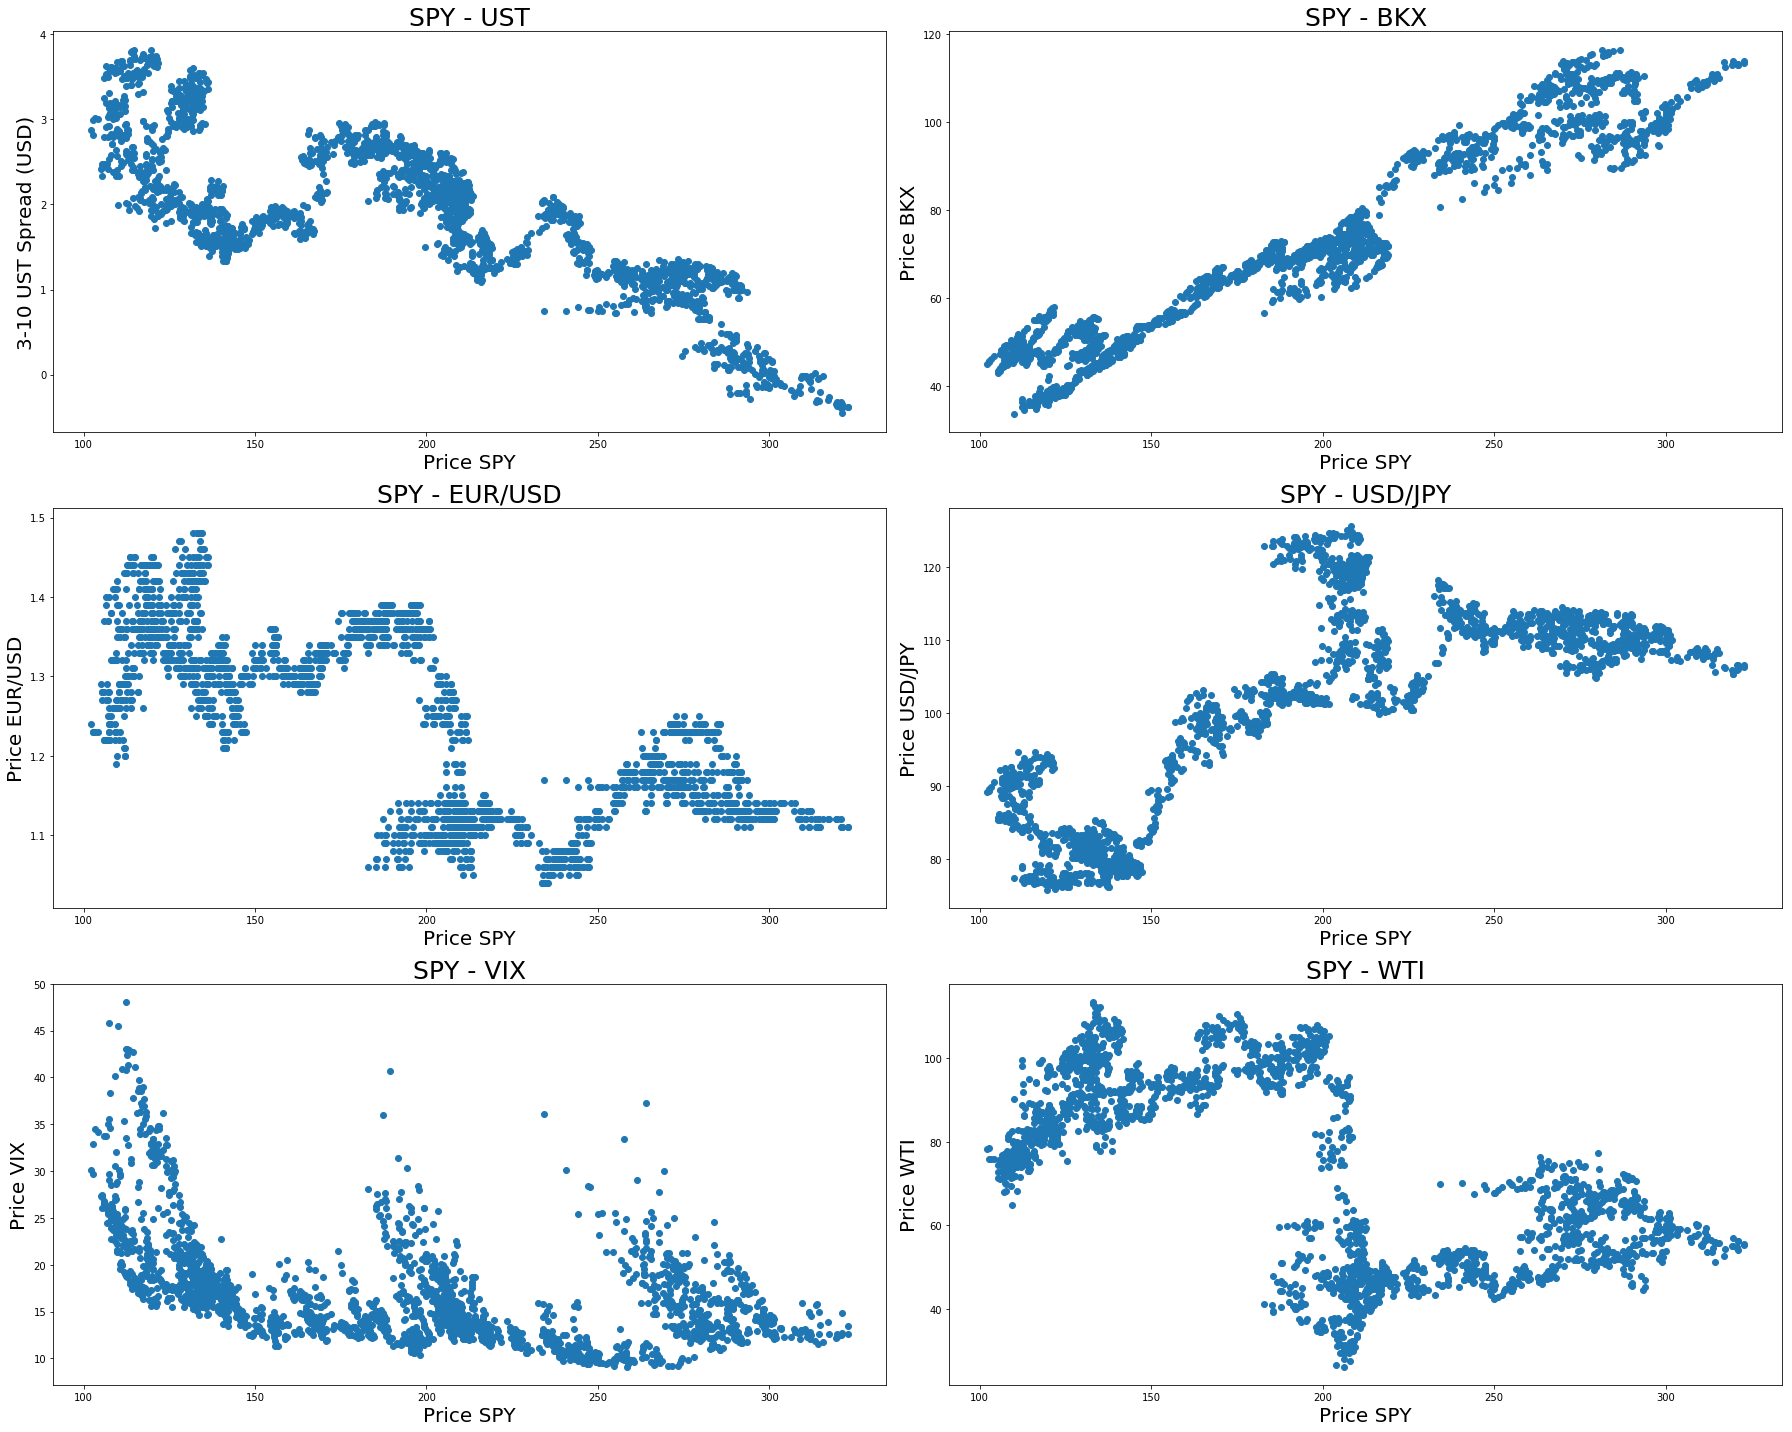

In [7]:
# Scatter plots of each feature and the SPY
f = plt.figure(figsize=(25,20))

# SPY - UST plot
ax = f.add_subplot(321)
plt.scatter(x=total_df['spy'], y=total_df['ust'])
plt.title('SPY - UST', size=25)
plt.xlabel('Price SPY', size=20)
plt.ylabel('3-10 UST Spread (USD)', size=20)

# SPY - BKX plot
ax1 = f.add_subplot(322)
plt.scatter(x=total_df['spy'], y=total_df['bkx'])
plt.title('SPY - BKX', size=25)
plt.xlabel('Price SPY', size=20)
plt.ylabel('Price BKX', size=20)

# SPY - EUR/USD plot
ax2 = f.add_subplot(323)
plt.scatter(x=total_df['spy'], y=total_df['eur'])
plt.title('SPY - EUR/USD', size=25)
plt.xlabel('Price SPY', size=20)
plt.ylabel('Price EUR/USD', size=20)

# SPY - USD/JPY plot
ax3 = f.add_subplot(324)
plt.scatter(x=total_df['spy'], y=total_df['jpy'])
plt.title('SPY - USD/JPY', size=25)
plt.xlabel('Price SPY', size=20)
plt.ylabel('Price USD/JPY', size=20)

# SPY - VIX plot
ax4 = f.add_subplot(325)
plt.scatter(x=total_df['spy'], y=total_df['vix'])
plt.title('SPY - VIX', size=25)
plt.xlabel('Price SPY', size=20)
plt.ylabel('Price VIX', size=20)

# SPY - WTI plot
ax5 = f.add_subplot(326)
plt.scatter(x=total_df['spy'], y=total_df['wti'])
plt.title('SPY - WTI', size=25)
plt.xlabel('Price SPY', size=20)
plt.ylabel('Price WTI', size=20)

plt.tight_layout()

#### The chart of the UST data in the upper left subplot above shows a strong downwards trend, and appears to be strongly negatively correlated with the price of the SPY.
#### At the upper right, the BKX shows a strong, positive correlation with the SPY, and it is trending upwards.
#### The EUR/USD seems to have a similar pattern as the UST data. There is likely some colinearity between the two. It, also appears to be negatively correlated with the SPY, and might show some cyclicality or seasonality.
#### For the most part, the USD/JPY data seem to be positively correlated with the SPY and are trending upwards.
#### The VIX data show a bit of a downtrend and show some cyclicality or seasonality.
#### The WTI data seem to show a downtrend, as well as a negative correlation with the SPY.

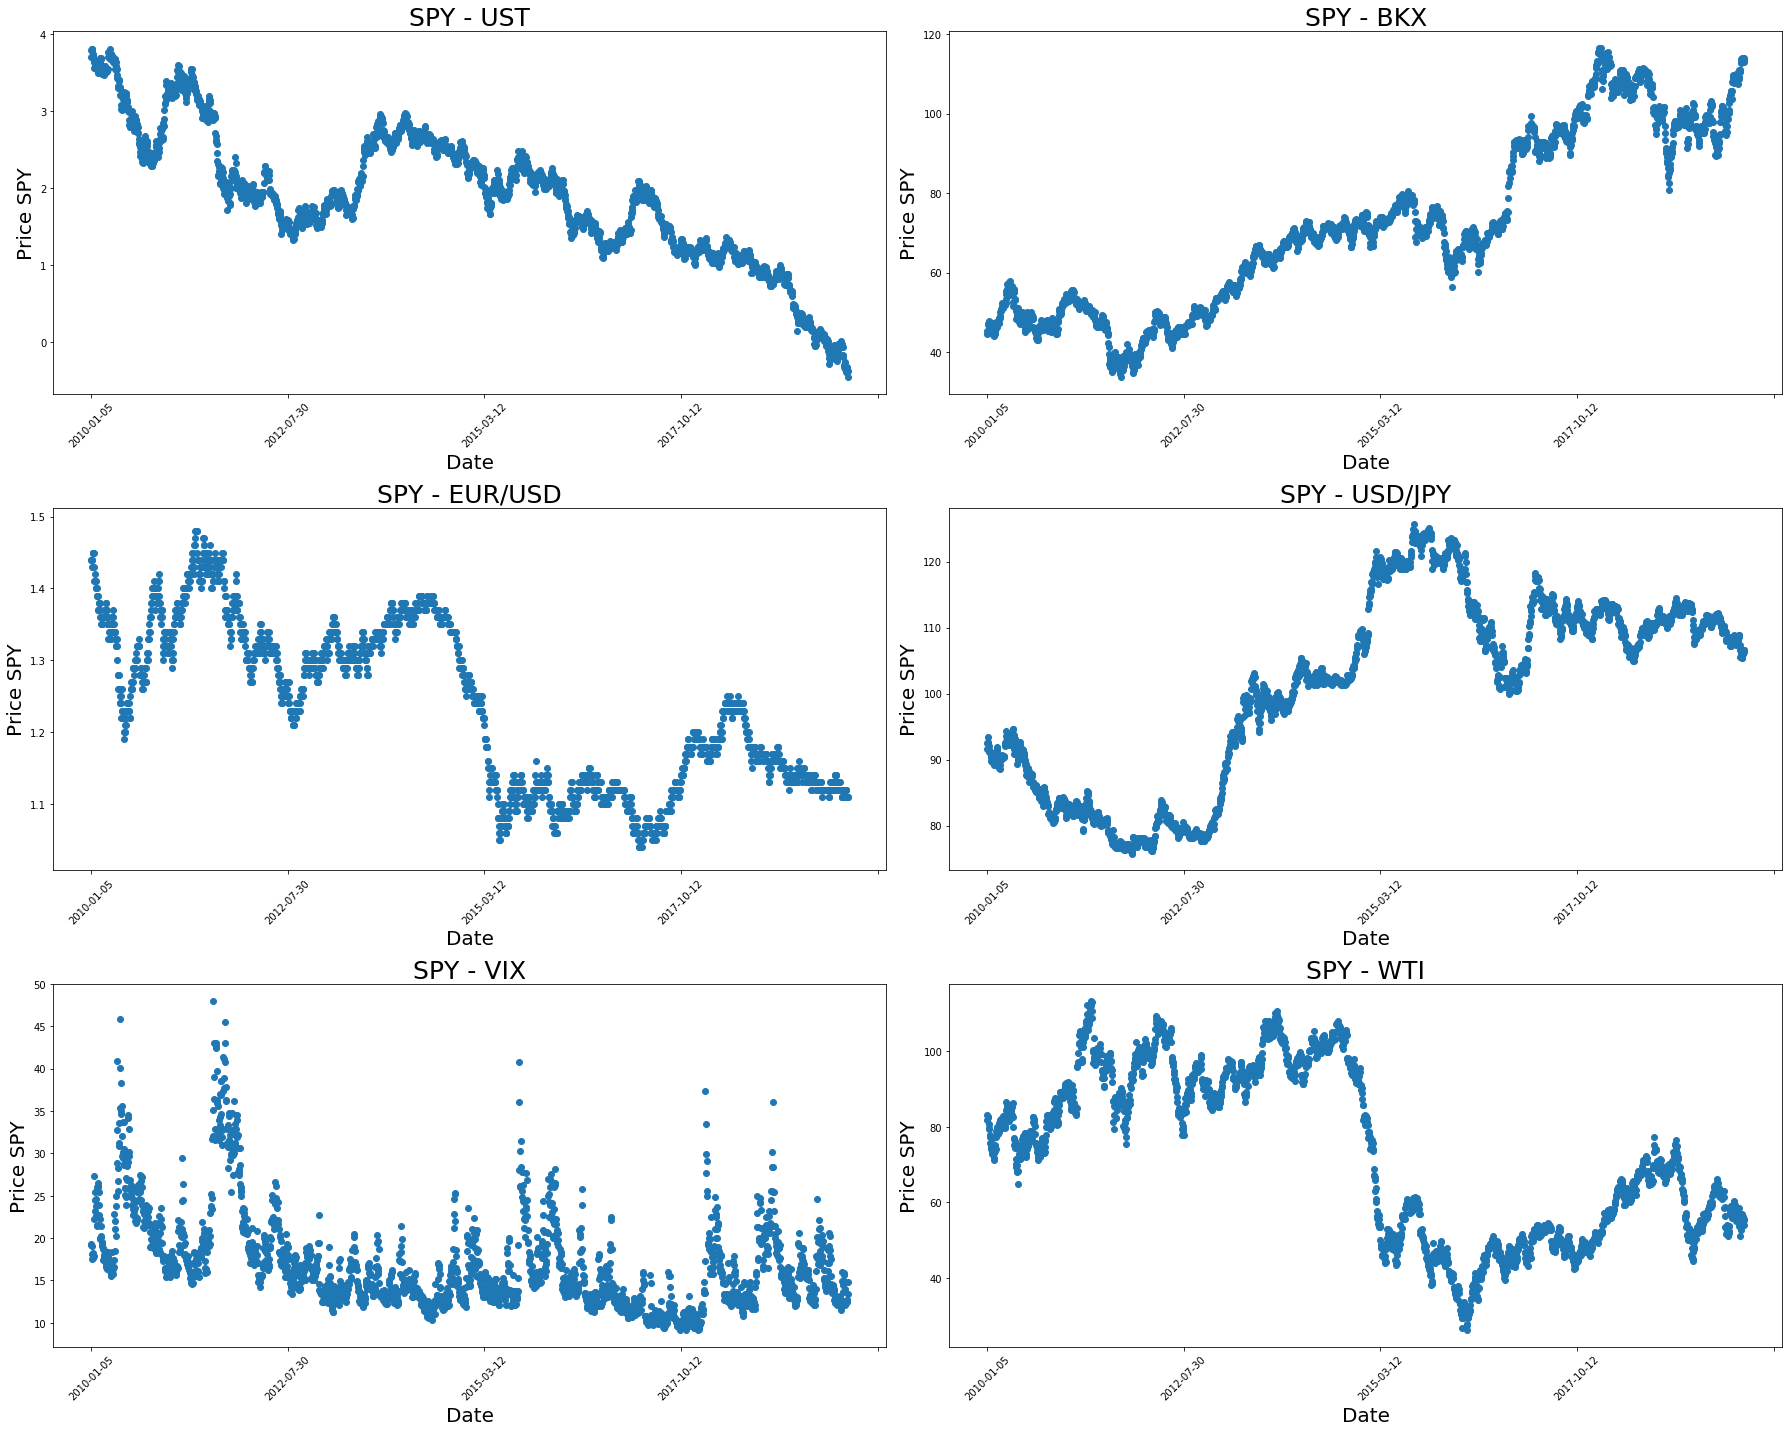

In [6]:
# Scatter plots of each feature
f = plt.figure(figsize=(25,20))

# UST plot
ax = f.add_subplot(321)
plt.scatter(total_df.index, total_df['ust'])
plt.title('SPY - UST', size=25)
plt.xlabel('Date', size=20)
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('Price SPY', size=20)

# BKX plot
ax1 = f.add_subplot(322)
plt.scatter(total_df.index, total_df['bkx'])
plt.title('SPY - BKX', size=25)
plt.xlabel('Date', size=20)
plt.xticks(rotation=45)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('Price SPY', size=20)

# EUR/USD plot
ax2 = f.add_subplot(323)
plt.scatter(total_df.index, total_df['eur'])
plt.title('SPY - EUR/USD', size=25)
plt.xlabel('Date', size=20)
plt.xticks(rotation=45)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('Price SPY', size=20)

# SD/JPY plot
ax3 = f.add_subplot(324)
plt.scatter(total_df.index, total_df['jpy'])
plt.title('SPY - USD/JPY', size=25)
plt.xlabel('Date', size=20)
plt.xticks(rotation=45)
ax3.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('Price SPY', size=20)

# VIX plot
ax4 = f.add_subplot(325)
plt.scatter(total_df.index, total_df['vix'])
plt.title('SPY - VIX', size=25)
plt.xlabel('Date', size=20)
plt.xticks(rotation=45)
ax4.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('Price SPY', size=20)

# WTI plot
ax5 = f.add_subplot(326)
plt.scatter(total_df.index, total_df['wti'])
plt.title('SPY - WTI', size=25)
plt.xlabel('Date', size=20)
plt.xticks(rotation=45)
ax5.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('Price SPY', size=20)

plt.tight_layout()

#### The UST data is clearly in a downtrend over time. It may reveal some seasonality.
#### The BKX data move upwards strongly, as well.
#### Overall, the EUR/USD data move downward, but might show some cyclicality.
#### The USD/JPY generally move upwards, too.
#### The VIX data show a decline overall, as well as some cyclicality.
#### The WTI data move lower, and might reveal some seasonality.

Text(0.5, 1.0, 'Correlation Heatmap')

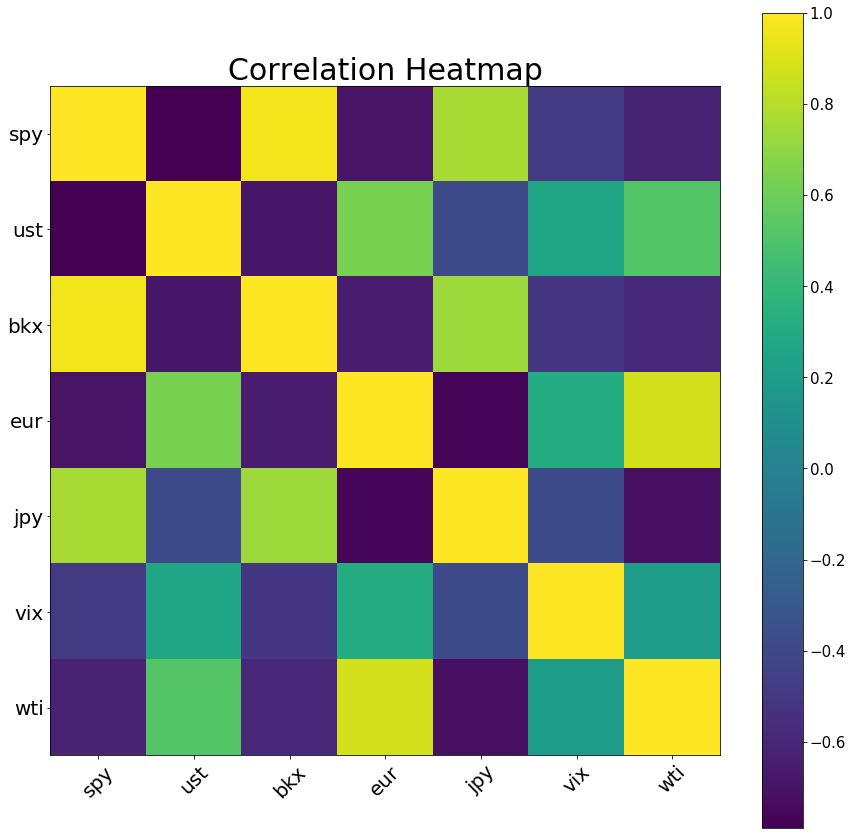

In [16]:
# Look here to annotate: https://matplotlib.org/3.1.3/gallery/images_contours_and_fields/image_annotated_heatmap.html
# Correlation heatmap
plt.figure(figsize=(15,15))
plt.imshow(total_df.corr())
plt.xticks(range(len(total_df.columns)), total_df.columns, rotation=45, fontsize=20)
plt.yticks(range(len(total_df.columns)), total_df.columns, fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title('Correlation Heatmap', size=30)

#### TODO: ADD NARRATIVE

# MODELS

### HELPER FUNCTIONS

In [9]:
# SS Residual
def calc_ss_resid(y, yhat):
    return sum((y - yhat) ** 2)

# SS Explained
def calc_ss_explain(y, yhat):
    return sum((yhat - np.mean(y)) ** 2)

# SS Total
def calc_ss_total(ss_explain, ss_resid):
    return ss_explain + ss_resid

# R-squared
def calc_r2(ss_resid, ss_total):
        return 1 - float(ss_resid / ss_total)
    
# Adjusted R-squared
def calc_adjust_r2(ss_residual, ss_total, n, k):
    return 1 - (ss_residual / (n - k - 1)) / (ss_total / (n - 1))

# MSE
def calc_mse(ss_resid, num_obs):
    return ss_resid / num_obs

# RMSE
def calc_rmse(rmse):
    return math.sqrt(rmse)

# MAE
def calc_mae(y, yhat, num_obs):
    return sum(abs(y - yhat)) / num_obs

# Calculate Residuals
def calc_resid(y, yhat):
    residuals = []
    for hat in yhat:
        residuals.append(y - yhat)
    return residuals

## TRAIN / TEST SPLITS

In [109]:
# Split the number of observations by 7/10 train/test
train_size = int(len(total_df) * 0.7)
test_size = int(len(total_df) - train_size)

print('Number of total training data observations: ', train_size)
print('Number of total test data observations: ', test_size)

# Train / test split
train = total_df[0:train_size]
test = total_df[train_size:len(total_df)]

# Split training data into 3 sets; 1 for each model
model_size = int(len(train) * 0.33)

# Split
train_ols = train[0:model_size]
train_pcr = train[model_size:(2 * model_size)]
train_sarimax = train[(2 * model_size):(3 * model_size)]

print('Number of OLS train / val data observations: ', len(train_ols))
print('Number of PCR train / val data observations: ', len(train_pcr))
print('Number of SARIMAX train / val data observations: ', len(train_sarimax))

Number of total training data observations:  1617
Number of total test data observations:  694
Number of OLS train / val data observations:  533
Number of PCR train / val data observations:  533
Number of SARIMAX train / val data observations:  533


## LINEAR REGRESSION
#### This is a naive regression to be used as a baseline. It does not include lagged variables to account for autocorrelation, and it does not include an differencing to account for any seasonality / cyclicality.

In [11]:
# Train / Val split

# Split
val_size = int(len(train_ols) * 0.5)
train_ols_val = train_ols[val_size:len(train_ols)]
train_ols = train_ols[0:val_size]

print('Total number of OLS training observations: ', len(train_ols))
print('Total number of OLS validation observations: ', len(train_ols_val))
print()
print(train_ols.columns)

# Create target vectors for both train and val sets
train_ols_Y = train_ols['spy']
train_ols_X = train_ols.drop('spy', axis=1)
train_ols_val_Y = train_ols_val['spy']
train_ols_val_X = train_ols_val.drop('spy', axis=1)

print()
print('Number of OLS training X observations: ', len(train_ols_X))
print('Number of OLS training Y value observations: ', len(train_ols_Y))
print('Number of OLS validation X value observations: ', len(train_ols_val_X))
print('Number of OLS validation Y value observations: ', len(train_ols_val_Y))

Total number of OLS training observations:  266
Total number of OLS validation observations:  267

Index(['spy', 'ust', 'bkx', 'eur', 'jpy', 'vix', 'wti'], dtype='object')

Number of OLS training X observations:  266
Number of OLS training Y value observations:  266
Number of OLS validation X value observations:  267
Number of OLS validation Y value observations:  267


In [12]:
# TODO:
# Normality test

In [13]:
# TODO:
# Durbin-Watson test

In [14]:
# Run scikit-learn linear regression model

# Run regression
regressor = LinearRegression()
regressor.fit(train_ols_X, train_ols_Y)

# Save intercept
ols_c = regressor.intercept_

# Save slopes
ols_B = regressor.coef_

print('Intercept: : ', ols_c)
print('Coefficients: ', ols_B)

# Predict
train_ols_y_hat = regressor.predict(train_ols_val_X)

# Validate
ss_e = calc_ss_explain(train_ols_val_Y, train_ols_y_hat)
ss_r = calc_ss_resid(train_ols_val_Y, train_ols_y_hat)
ss_t = calc_ss_total(ss_e, ss_r)
r2 = calc_r2(ss_r, ss_t)
ar2 = calc_adjust_r2(ss_r, ss_t, len(train_ols_y_hat), len(train_ols_val_X.columns))
mse = calc_mse(ss_r, len(train_ols_y_hat))
rmse = calc_rmse(mse)

print('SSE: ', ss_e)
print('SSR: ', ss_r)
print('SST: ', ss_t)
print('R2: ', r2)
print('Adjusted R2: ', ar2)
print('MSE: ', mse)
print('RMSE: ', rmse)

Intercept: :  100.76176880353852
Coefficients:  [ 2.1925108   1.21954558 19.2894108  -1.07625201 -0.07242985  0.22822166]
SSE:  25926.71933173928
SSR:  17331.695493818297
SST:  43258.41482555758
R2:  0.5993451086058168
Adjusted R2:  0.5900992264967202
MSE:  64.91271720531198
RMSE:  8.056842880763654


#### The results of the baseline linear regression model are above. The intercept is 100.76 and the coefficients are 2.19, 1.22, 19.29, -1.08, -0.07, and 0.23 for the UST, BKX, EUR, JPY, VIX, and WTI variables,  respectively.
#### The coefficient on the 3-10 Spread is positive.
#### The coefficient for the BKX is positive. This is in line with theory. As banks do well, so, too does the overall economy.
#### The EUR/USD is positively correlated with the price of the SPY, but the EUR/USD cross is a ratio, so there is an added layer to its interpretation. In short, the model suggests that as the price of the SPY goes up, the value of the USD relative to the Euro goes down. This could be due to inflation as the US economy experiences growth that is reflected in the price of the SPY. Also, investors are less likely to hold cash as the economy is growing. 
#### The negative sign on the JPY coefficent suggests that for each 1.08 unit increase in the USD/JPY, the price of the SPY will decline by 1. This aligns with theory. Historically, the Yen is a safe haven for investors seeking to limit losses in down markets. With such low interest rates, the BOJ is not able to cut rates as drastically as other reserve banks.
#### The sign on the coefficient for the price of the VIX is, also negative. This makes sense given the fact that the VIX is considered to be a 'fear index'. What is interesting, however, is the magnitude. It doesn't seem to be that signficant. But, in the context of the timeframe of our data, it makes a bit more sense. The stock market, and the SPY, have been steadily increasing during this timeframe. One might think that the VIX, as a measure of volatility, would move higher along with those prices, but the VIX weights down moves in prices more heavily than moves upward. So, it really is more of a 'fear index' than it is a volatility index.
#### The model has an R-squared of 0.599. These set of features explain 59.9% of the variability of the price of the SPY. The Adjusted R-squared is 0.590. Finally, the Mean Squared Error is 64.91.

Text(0, 0.5, 'Residuals')

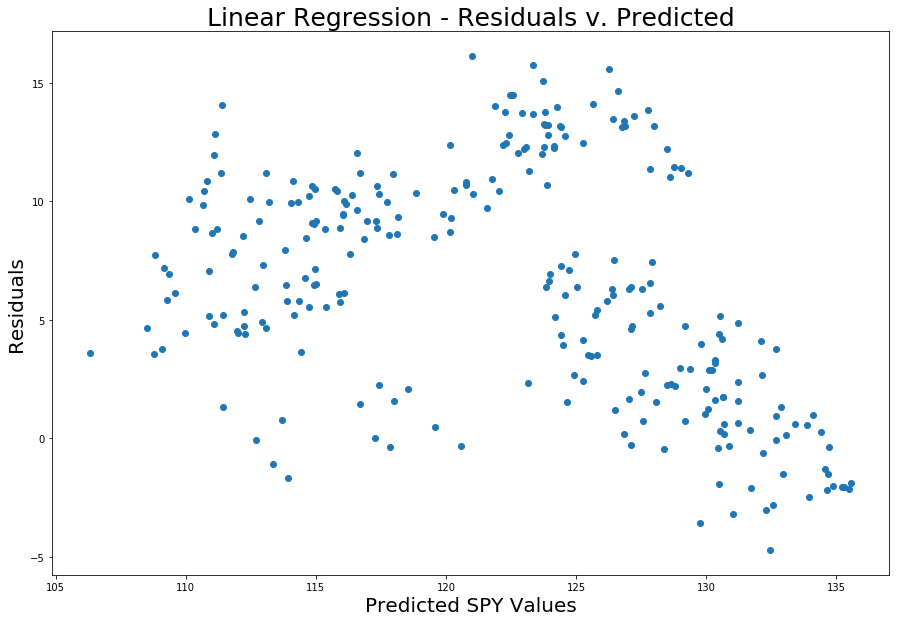

In [100]:
# Plot the residuals against actual values

# Create series containing residual values
train_ols_resid = pd.Series(train_ols_val_Y - train_ols_y_hat)

# Plot
f = plt.figure(figsize=(15,10))
plt.scatter(train_ols_y_hat, train_ols_resid)
plt.title("Linear Regression - Residuals v. Predicted", size=25)
plt.xlabel("Predicted SPY Values", size=20)
plt.ylabel("Residuals", size=20)

#### Above is a plot of the predicted SPY values and the residuals from the previous linear regression. The error term, or residual is the difference between the actual value of y and the predicted value. The variance of the error term should be constant for all observations. And, we can see from the plot, that this is not the case. As the predicted value of y increases to ~120, the variance of the residual seems to decrease. Then, as the predicted value of increases to ~128, the variance increases, and it decreases again to ~135. So, it appears that there is some an underlying structure or heterocskadasticity here.

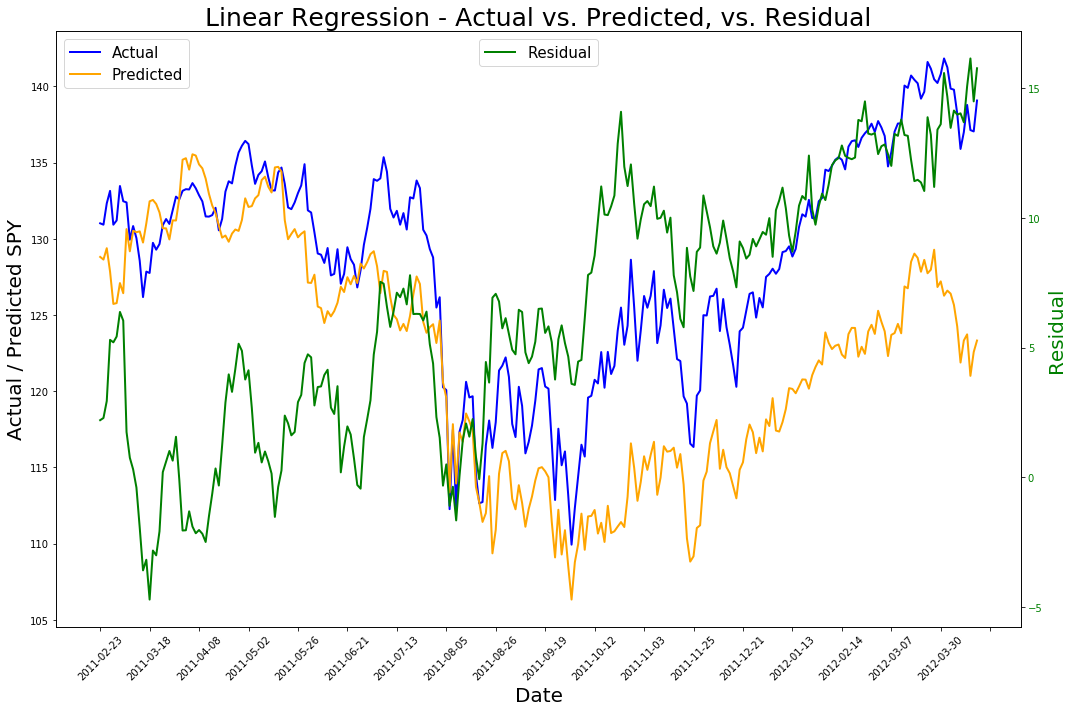

In [99]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Plot actual and fitted values
f = plt.figure(figsize=(15,10))
plt.title('Linear Regression - Actual vs. Predicted, vs. Residual', size=25)

# Left-hand scale, SPY actual values in USD
ax = f.add_subplot(111)
ax.plot(train_ols_val_Y, color='blue', linewidth=2, label='Actual')
ax.set_ylabel('Actual / Predicted SPY', size=20)
ax.set_xlabel('Date', size=20)
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(plt.MaxNLocator(25))

# Left-hand scale, SPY predicted values in USD
ax.plot(train_ols_y_hat, color='orange', linewidth=2, label='Predicted')
ax.legend(loc='upper left', prop={'size':15})

# Right-hand scale is Residual in USD
ax2 = ax.twinx()
ax2.plot(train_ols_resid, color='green', linewidth=2, label='Residual')
ax2.set_ylabel('Residual', size=20, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.xaxis.set_major_locator(plt.MaxNLocator(25))
ax2.legend(loc='upper center', prop={'size':15})

f.tight_layout()

#### In the plot above, we can see that this model produces some predicted values that are pretty far from the actual values. In particular, it looks like the error increases dramatically from 2011-09-19 on.

## PRINCIPAL COMPONENTS REGRESSION

In [92]:
# Train / Val split

# Split 50/50 train/val
val_size = int(len(train_pcr) * 0.5)
train_pcr_val = train_pcr[val_size:len(train_pcr)]
train_pcr = train_pcr[0:val_size]

print('Total number of PCR training observations: ', len(train_pcr))
print('Total number of OLS validation observation: ', len(train_pcr_val))
print()
print(train_pcr.columns)
print()

# Create target vectors for both train and val sets
train_pcr_Y = train_pcr['spy']
train_pcr_X = train_pcr.drop('spy', axis=1)
train_pcr_val_Y = train_pcr_val['spy']
train_pcr_val_X = train_pcr_val.drop('spy', axis=1)

print('Number of PCR training X observations: ', len(train_pcr_X))
print('Number of PCR training Y value observations: ', len(train_pcr_Y))
print('Number of PCR validation X value observations: ', len(train_pcr_val_X))
print('Number of PCR validation Y value observations: ', len(train_pcr_val_Y))

Total number of PCR training observations:  266
Total number of OLS validation observation:  267

Index(['spy', 'ust', 'bkx', 'eur', 'jpy', 'vix', 'wti'], dtype='object')

Number of PCR training X observations:  266
Number of PCR training Y value observations:  266
Number of PCR validation X value observations:  267
Number of PCR validation Y value observations:  267


In [93]:
# TODO:
# Normality test

In [94]:
# Perform PCA

# Look for components that account for 95% of variation
var1 = 0.95
pca = PCA(var1)

# Center training data
train_pcr_X -= train_pcr_X.mean(axis=0)

# Fit the PCA model
train_pcr_X = pca.fit_transform(train_pcr_X)

print('Dimensions of compenents: ', train_pcr_X.shape)
print('Minimum number of components that account for', var1, '% of the variance: ', pca.n_components_)

pc_sum = 100 * round(sum(pca.explained_variance_ratio_[:2]), 4)
print('The first two components explain ', pc_sum, '% of the variance')

pc1_var = 100 * round(float(pca.explained_variance_ratio_[0]), 3)
pc2_var =  100 * round(float(pca.explained_variance_ratio_[1]), 3)
pc3_var =  100 * round(float(pca.explained_variance_ratio_[2]), 3)
print('Variance captured by 1st PC: ', pc1_var, '%')
print('Variance captured by 2nd PC: ', pc2_var, '%')

# Collect data into df
pc_vars = pd.Series([pc1_var, pc2_var, pc3_var])
pc_labels = pd.Series(['PC-1', 'PC-2', 'PC-3'])
pc_df = pd.DataFrame(pd.concat([pc_labels, pc_vars], axis=1))
print(pc_df)

Dimensions of compenents:  (266, 3)
Minimum number of components that account for 0.95 % of the variance:  3
The first two components explain  91.77 % of the variance
Variance captured by 1st PC:  60.6 %
Variance captured by 2nd PC:  31.2 %
      0     1
0  PC-1  60.6
1  PC-2  31.2
2  PC-3   6.7


#### The variance set to be captured by the PCA is 95%. The first component account for 60.6% of the variation of the feature set. The second and third account for 31.2 and 6.7 percent, respectively. Cumulatively, the first two components account for 91.8 percent. If we include the third, they will be quite close to 100 percent. For this reason, the first two components are chosen to be regressors in the linear regression to follow.

(55, 102)

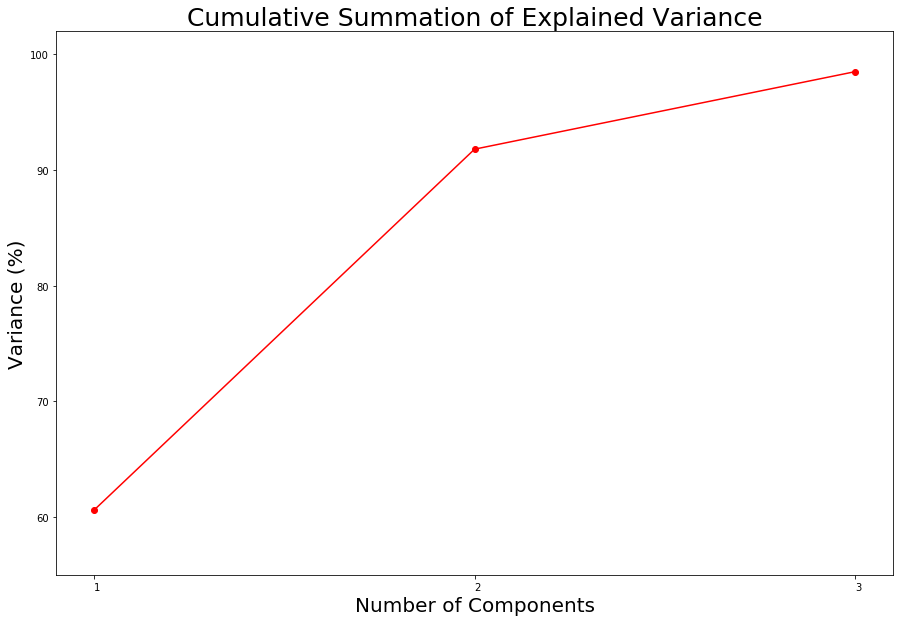

In [95]:
# Plot the cumulative summation of the explained variance
f = plt.figure(figsize=(15,10))
num_comps = [1, 2, 3]
plt.plot(num_comps, np.cumsum(pc_vars),'ro-')
plt.title('Cumulative Summation of Explained Variance', size=25)
plt.xlabel('Number of Components', size=20)
plt.xticks(num_comps, ha='left')
plt.ylabel('Variance (%)', size=20)
plt.ylim(55, 102)

#### It helps to visualize the cumulative change in variance per principal component using the scree plot above. From it, we can see that the first principal component accounts for more than 60 percent of the variance in the feature set. Once the second principal component is included, the cumulative variance accounted for by the first two principal components is more than 90 percent. Including just these two components in the linear regression below should be sufficient. If we add the third principal component, the explained variance climbs to just under 100 percent, however doing so could lead to overfitting.

In [96]:
# Run scikit-learn regression
regressor = LinearRegression()
regressor.fit(train_pcr_X[:,0:2], train_pcr_Y)

# Save intercept
pcr_c = regressor.intercept_

# Save slopes
pcr_B = regressor.coef_

print('Intercept: : ', pcr_c)
print('Coefficients: ', pcr_B)

# Prediction

# Center training data
train_pcr_val_X -= train_pcr_val_X.mean(axis=0)

# Fit the PCA model; keep only the first two components
train_pcr_val_X = pca.fit_transform(train_pcr_val_X)[:,0:2]

train_pcr_val_X = pd.DataFrame(train_pcr_val_X)

# Predict
train_pcr_y_hat = regressor.predict(train_pcr_val_X)

# Validate
ss_e = calc_ss_explain(train_pcr_val_Y, train_pcr_y_hat)
ss_r = calc_ss_resid(train_pcr_val_Y, train_pcr_y_hat)
ss_t = calc_ss_total(ss_e, ss_r)
r2 = calc_r2(ss_r, ss_t)
ar2 = calc_adjust_r2(ss_r, ss_t, len(train_pcr_y_hat), len(train_pcr_val_X.columns))
mse = calc_mse(ss_r, len(train_pcr_y_hat))
rmse = calc_rmse(mse)

print('SSE: ', ss_e)
print('SSR: ', ss_r)
print('SST: ', ss_t)
print('R2: ', r2)
print('Adjusted R2: ', ar2)
print('MSE: ', mse)
print('RMSE: ', rmse)

Intercept: :  145.79515037593984
Coefficients:  [ 1.10951385 -0.2745305 ]
SSE:  327958.5564093764
SSR:  360757.6054559433
SST:  688716.1618653197
R2:  0.4761882682136179
Adjusted R2:  0.4722199975182666
MSE:  1351.1520803593382
RMSE:  36.75802062624344


#### The results of the Principal Components Regression might seem less promising than the those of the Linear Regression. However, PCR implements Principal Component Analysis on the feature set. The resulting principal components are then used as inputs to the linear regression to model the dependent variable. PCA removes data from our set which helps to limit overfitting. In doing so, the portion of the dependent variable's variance explained by regressing the principal components on that dependent variable is likely to decrease. A strength of the PCR model is that by using the principal components from the PCA decrease colinearity. This helps to ensure that one of the assumptions required of linear regression models, namely that our explanatory variables are independent, holds. And, for this reason, this PCR model is preferred over the previous OLS model. Unfortunately, the interpretation of PCR models can be difficult given that the inputs to the linear regression model are more complex. The R-squared and Adjusted R-squared of our model are 0.476 and 0.472, respectively. And, it has a Mean Squared Error of 1351.15.

#### A note worth mentioning about PCA is that because it is unsupervised, it does not consider the response variable when choosing which principal components to drop. It chooses principal components that capture the greatest amount of variation of the set of featurs. However, there might not be reason to believe that the feature components with the greatest variance are the best explanatory variables to use to predict a response variable.

#### While Principal Component Regression can be used to address colinearities among the explanatory variables, as well as to model data for which there are more explanatory variables then there are observations, it is not without drawbacks. Something to keep in mind is that because it is unsupervised, it does not consider the response variable when choosing which principal components to drop. It chooses principal components that capture the greatest amount of variation. However, there is not no reason to believe that principal components with the greatest variance are the best to predict the response variable.

Text(0, 0.5, 'Residuals')

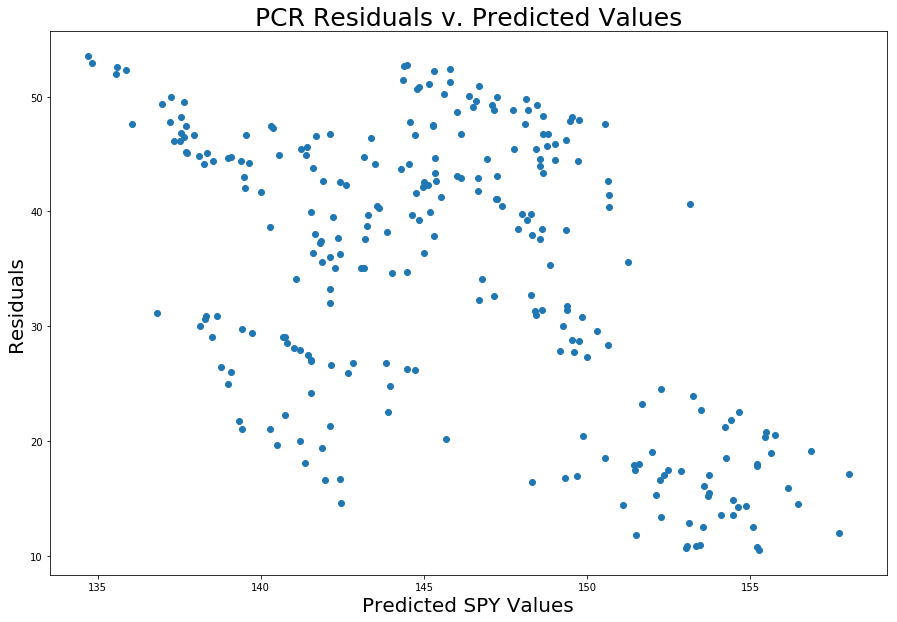

In [98]:
# Plot the residuals against predicted values

# Create series containing residual values
train_pcr_resid = pd.Series(train_pcr_val_Y - train_pcr_y_hat)

# Plot
f = plt.figure(figsize=(15,10))
plt.scatter(train_pcr_y_hat, train_pcr_resid)
plt.title("PCR Residuals v. Predicted Values", size=25)
plt.xlabel("Predicted SPY Values", size=20)
plt.ylabel("Residuals", size=20)

# Add narrative

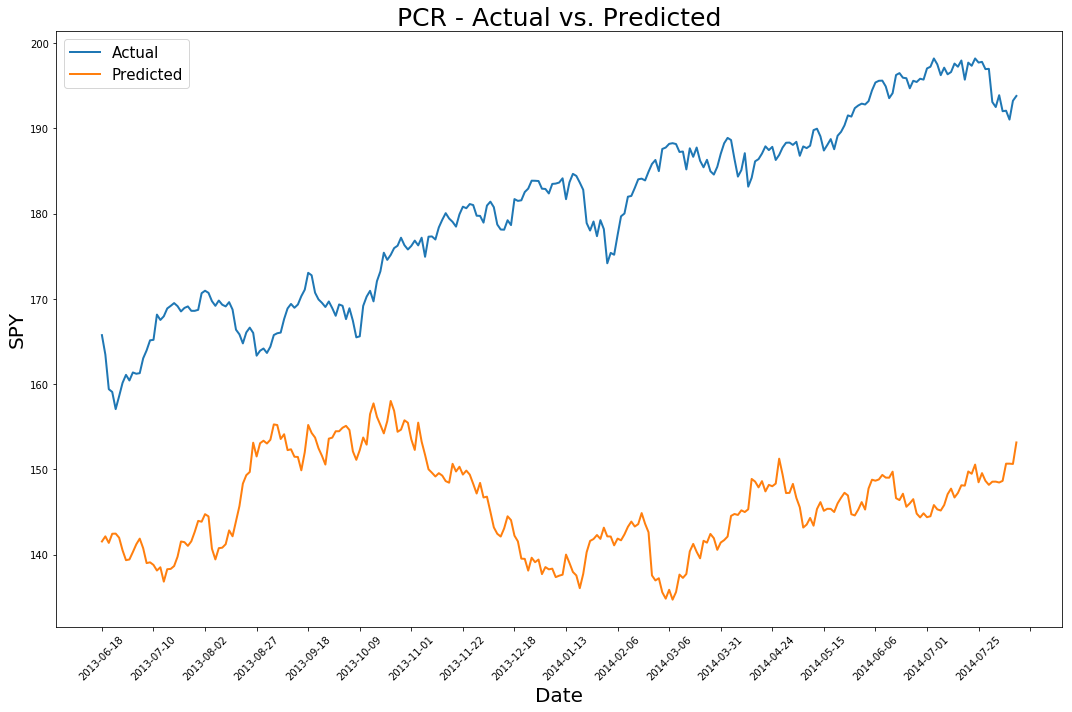

In [103]:
# Plot actual and fitted values
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
plt.plot(train_pcr_val_Y, linewidth=2, label='Actual')
plt.plot(train_pcr_y_hat, linewidth=2, label='Predicted')
plt.title("PCR - Actual vs. Predicted", size=25)
ax.set_xlabel('Date', size=20)
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(plt.MaxNLocator(25))
ax.set_ylabel('SPY', size=20)
plt.legend(loc='upper left', prop={'size':15})
plt.tight_layout()

## SEASONAL AUTOREGRESSIVE INTEGRATED MOVING AVERAGE WITH EXOGENOUS REGRESSORS

#### Neither the OLS nor the PCR models performed very well. It is important to remember that this is time series data. Each value is influenced by the previous values. So, let us take a look at a model that can use the information contained in previous values to predict future values. One such model is the Autoregressive Integrative Moving Average model that follows. But, first, let us explore the data before we commit to a model.

In [110]:
# Train / Val split

# Split
val_size = int(len(train_sarimax) * 0.5)
train_sarimax_val = train_sarimax[val_size:len(train_sarimax)]
train_sarimax = train_sarimax[0:val_size]

print('Total number of SARIMAX training observations: ', len(train_sarimax))
print('Total number of SARIMAX validation observations: ', len(train_sarimax_val))
print()
print(train_sarimax.columns)

# Create target vectors for both train and val sets
train_sarimax_Y = train_sarimax['spy']
train_sarimax_X = train_sarimax.drop('spy', axis=1)
train_sarimax_val_Y = train_sarimax_val['spy']
train_sarimax_val_X = train_sarimax_val.drop('spy', axis=1)

print()
print('Number of SARIMAX training X observations: ', len(train_sarimax_X))
print('Number of SARIMAX training Y value observations: ', len(train_sarimax_Y))
print('Number of SARIMAX validation X value observations: ', len(train_sarimax_val_X))
print('Number of SARIMAX validation Y value observations: ', len(train_sarimax_val_Y))

Total number of SARIMAX training observations:  266
Total number of SARIMAX validation observations:  267

Index(['spy', 'ust', 'bkx', 'eur', 'jpy', 'vix', 'wti'], dtype='object')

Number of SARIMAX training X observations:  266
Number of SARIMAX training Y value observations:  266
Number of SARIMAX validation X value observations:  267
Number of SARIMAX validation Y value observations:  267


In [36]:
# Box-Jenkins Methodology


Text(0, 0.5, 'y(t + 1)')

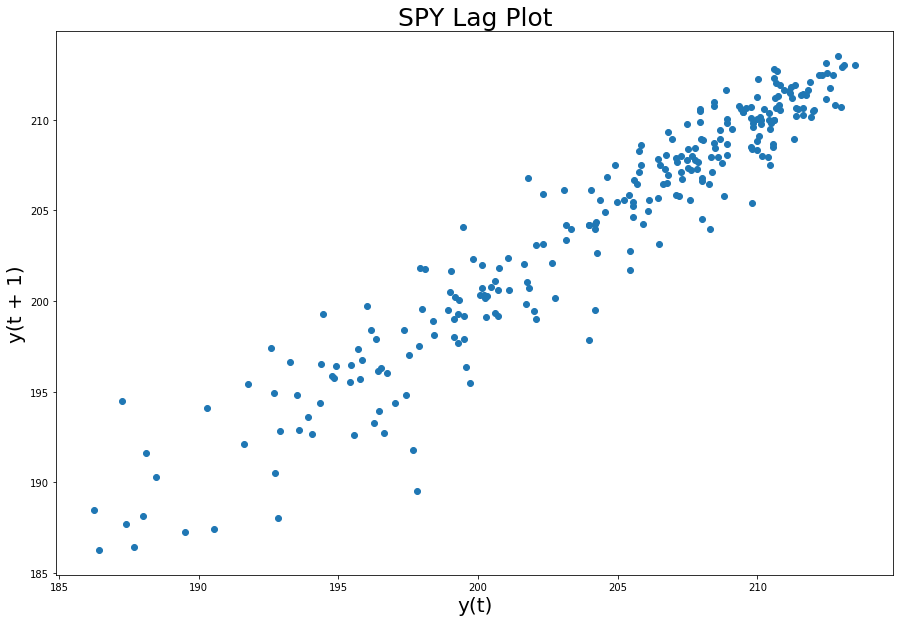

In [112]:
# Lag plot
f = plt.figure(figsize=(15, 10))
lag_plot(train_sarimax_Y)
plt.title('SPY Lag Plot', size=25)
plt.xlabel('y(t)', size=20)
plt.ylabel('y(t + 1)', size=20)

#### A lag plot checks whether or not time series data are random. If they are random, there should not be any pattern or structure to the plot. From the lag plot shown above, a strong correlation between each daily close of the SPY and the previous day's close. And, we can see that as the correlation seems to increase as the price of the SPY does the same. This suggests that an autoregressive model might be appropriate. But, let us calculate the correlation between them below.

In [38]:
# Pearson correlation coefficient
values = pd.DataFrame(train_sarimax['spy'])
correlation_df = pd.concat([values.shift(1), values], axis=1)
correlation_df.columns = ['t-1', 't']
result = correlation_df.corr()
print(result)

          t-1         t
t-1  1.000000  0.956921
t    0.956921  1.000000


#### As suspected, the correlation between the SPY closing price with the previous closing price is very high. Next, take a look at the autocorrelation plot below.

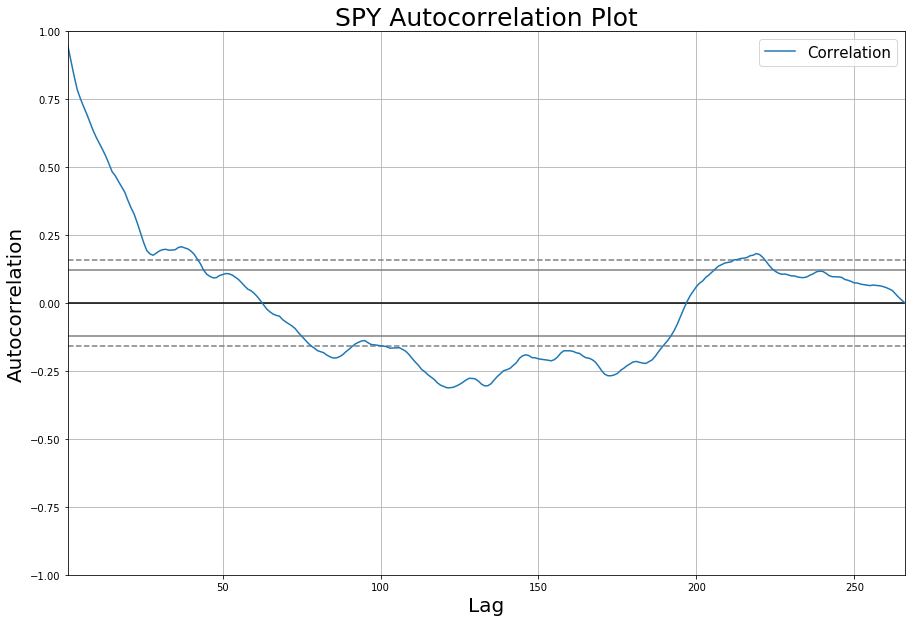

In [113]:
# Autocorrelation plot
f = plt.figure(figsize=(15,10))
autocorrelation_plot(train_sarimax_Y, label='Correlation')
plt.title("SPY Autocorrelation Plot", size=25)
plt.xlabel('Lag', size=20)
plt.ylabel('Autocorrelation', size=20)
plt.legend(prop={'size':15})

#### Similar to the lag plot, an autocorrelation plot checks for randomness in data. If the data are random, they will not be correlated. This means that the values displayed in an autocorrelation plot should be at or near zero. From the autocorrelation plot above, we can see that the correlations between each value and previous values are not non-zero. In fact, some are very high. And, the correlation swings from positive to negative and back. This suggests that there is some cyclicality to the data. It looks like the correlation decreases roughly over 125 periods and increases over periods of roughly 100. The dashed line represents the 95% confident interval for those values. The information displayed in the plot suggests that an autoregressive model might be appropriate.

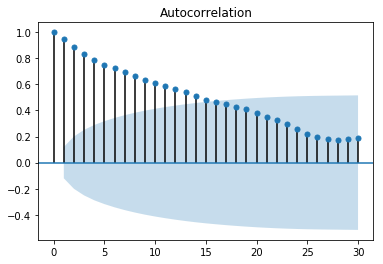

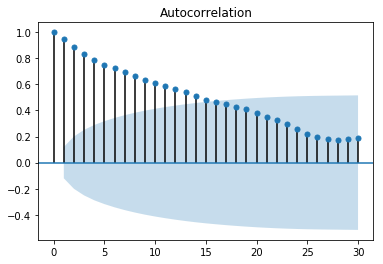

In [117]:
# Autocorrelation line plot with a limit of 30 lag periods displayed
plot_acf(train_sarimax_Y, lags=30)

#### The autocorrelation plot above seems to reveal a slow decay as the correlation approaches zero. This suggests that the data follow a long-memory process. But, what happens to that correlation as we look back even further in time?

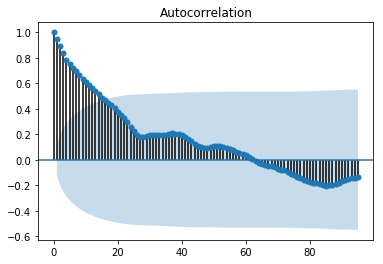

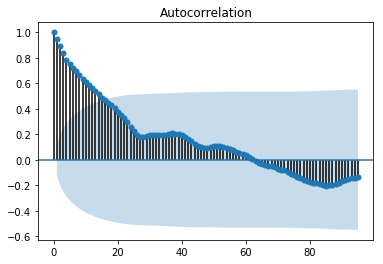

In [118]:
# Autocorrelation line plot with a limit of 60 lag periods displayed
plot_acf(train_sarimax_Y, lags=95)

#### From the autocorrelation plots above, we can see that the correlation between the SPY closing price and previous prices is at or near zero. The correlation between the SPY and previous values seems to equal zero around 95 days. But, what happens if we look even further than that?

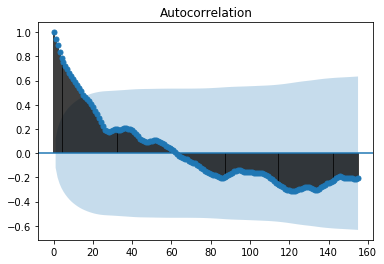

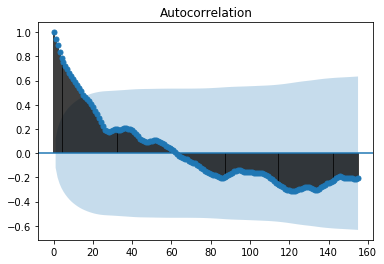

In [119]:
# Autocorrelation line plot with a limit of 60 lag periods displayed
plot_acf(train_sarimax_Y, lags=155)

#### It appears to be the case that around 130 days, the magnitude of the negative correlation between the SPY closing price and previous values peaks. It seems to reverse and head back toward zero. And, in fact, it does. There is a strong structure to the correlation of the SPY closing price and previous prices. And, these data, also suggest that there is a seasonality or cyclical nature to the independent variable. This, too, suggests that an autoregressive model might be appropriate. Let us take another look at a the SPY data by itself.

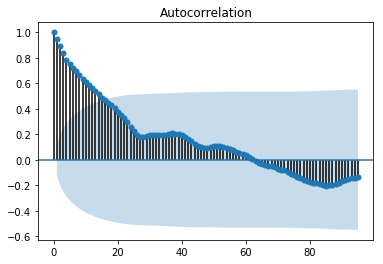

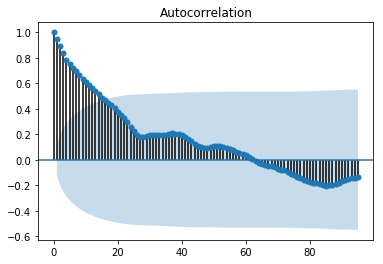

In [120]:
# Autocorrelation line plot with a limit of 60 lag periods displayed
plot_acf(train_sarimax_Y, lags=95)

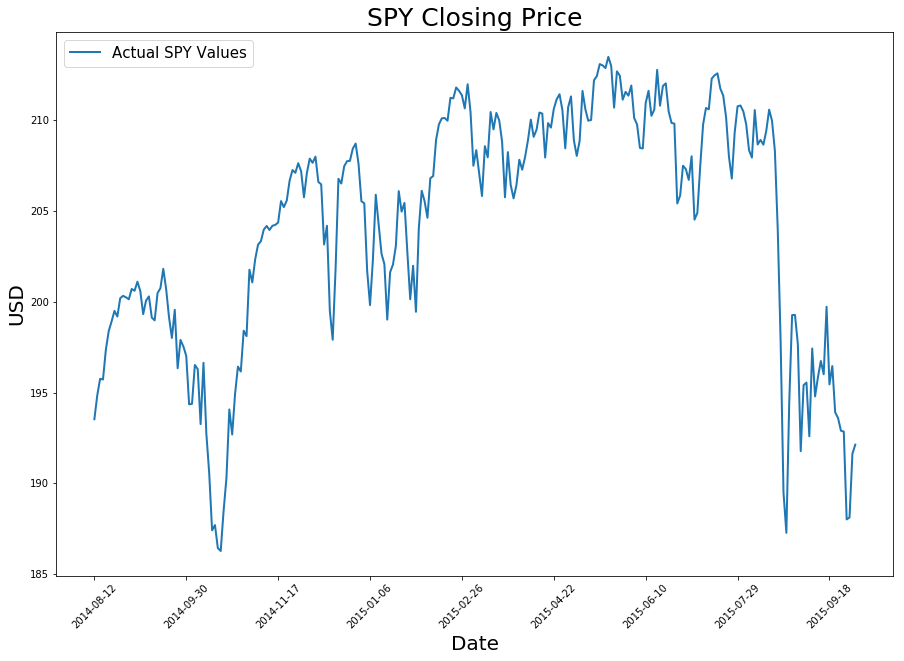

In [126]:
# Plot SPY data by itself
f = plt.figure(figsize=(15,10))
ax = plt.axes()
plt.plot(train_sarimax_Y, linewidth=2, label='Actual SPY Values')
plt.title('SPY Closing Price', size=25)
plt.xticks(rotation=45)
tick_spacing = 32
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.ylabel('USD', size=20)
plt.xlabel('Date', size=20)
plt.legend(loc='upper left', prop={'size':15})

#### Above, it appears that the SPY data do not maintain the same variance throughout. That is to say, if we look at a subsection of the plot, the SPY data will have one variance. And, if we look at some other subsection of the plot, the data might have a different variance. Specifically, if we consider the variance between 1,300 and 1,400, it is much smaller than the variance between 1,400 and 1,540. The lack of constant variance and constant autocorrelation suggests that our data are not stationary. One of the assumptions of modeling time series data is that it is stationary. So, we will have to address that somehow.

#### After closely examining the plot, it appears that upwards moves last roughly 45 days and that moves downwards last roughly 30 days. The average of these two numbers is 37.5, but we will use 37 days for the frequency in the decomposition below. It is important to note that this is just a simple approximation. 

37


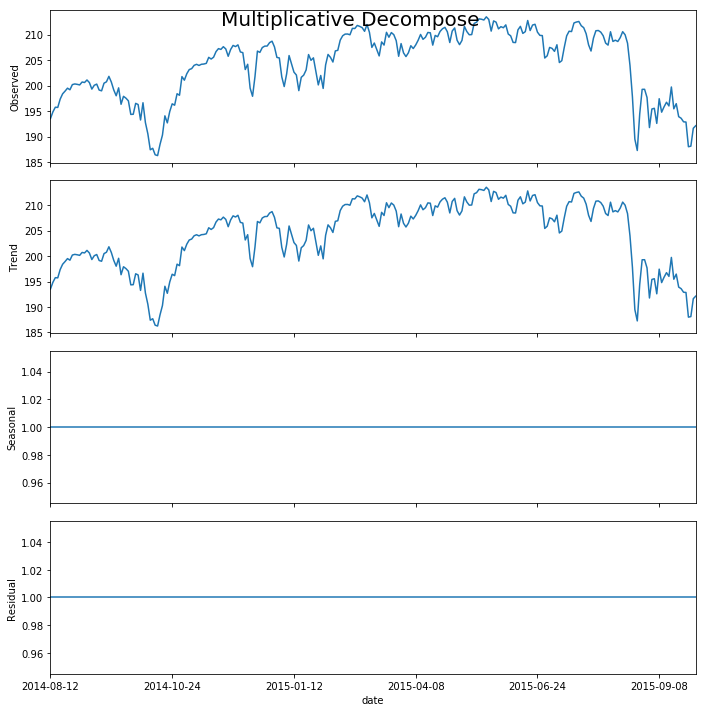

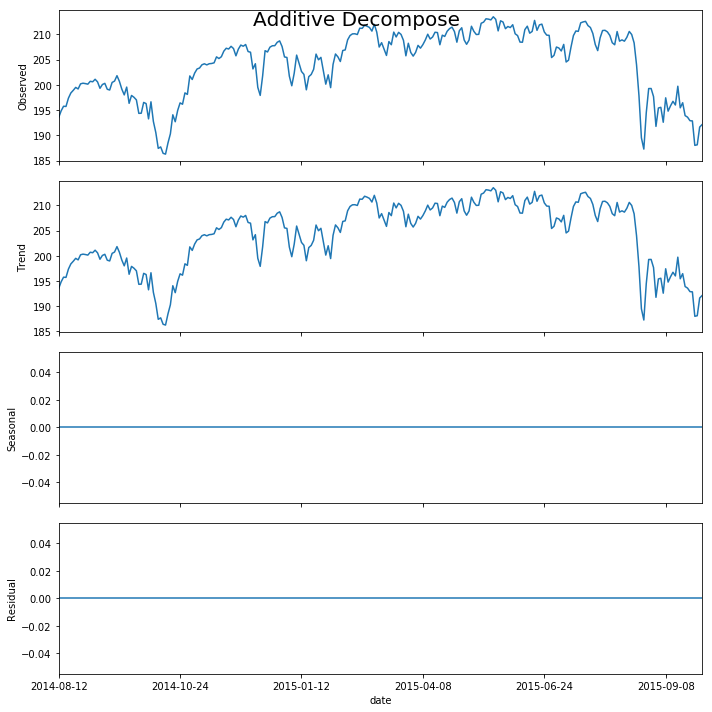

In [127]:
# Frequency
up = 45
down = 30
avg_freq = int((up + down) / 2)
print(avg_freq)
# Multiplicative Decomposition 
result_mul = seasonal_decompose(spy_df, model='multiplicative', freq=1)

# Additive Decomposition
result_add = seasonal_decompose(spy_df, model='additive', freq=1)

# Create plots
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
result_add.plot().suptitle('Additive Decompose', fontsize=20)

plt.tight_layout()

#### In time series data, there are three types of patterns: Trend, Seasonality, and Cycles. When time series data are decomposed, these patterns are observable. Frequently, the trend and cycle components are combined into a single component. Therefore, time series data can be thought of as being comprised of three components: Trend-Cycle, Seasonal, and a Remainder which contains noise. This can be written as: y_{t} = S_{t} + T_{t} + R_t,
#### Above are two decompositions of the SPY data. The one on just above is an Additive Decomposition, and the one above that is a Multiplicative Decomposition. The additive decomposition is of the form previously discussed. That is to say, that each value of each response variable is a composed of the sum of each part: trend-cycle, seasonal, and a remainder. The multiplicative decomposition includes these same components, but differs in that the response variable is the product of these parts. Or, y_{t} = S_{t} \times T_{t} \times R_t.

37


Text(0.5, 0.98, 'Additive Decompose')

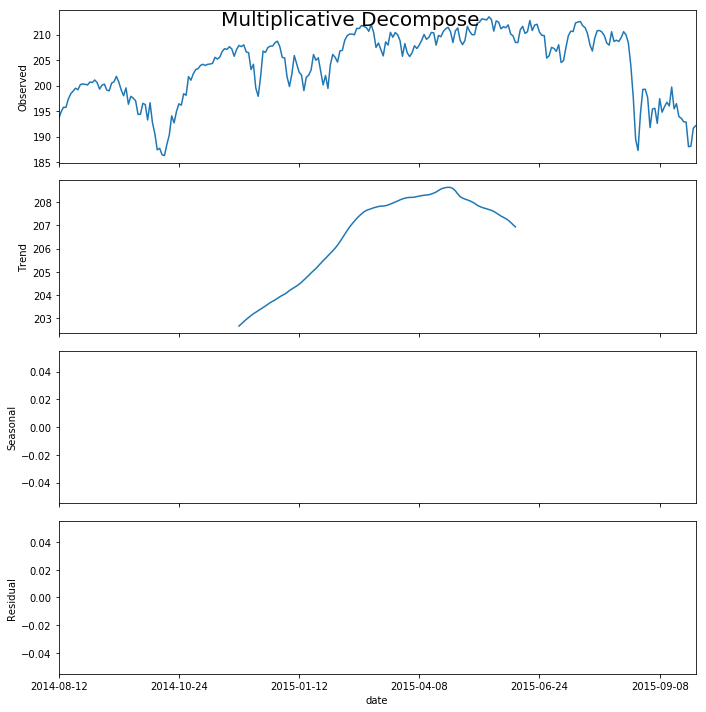

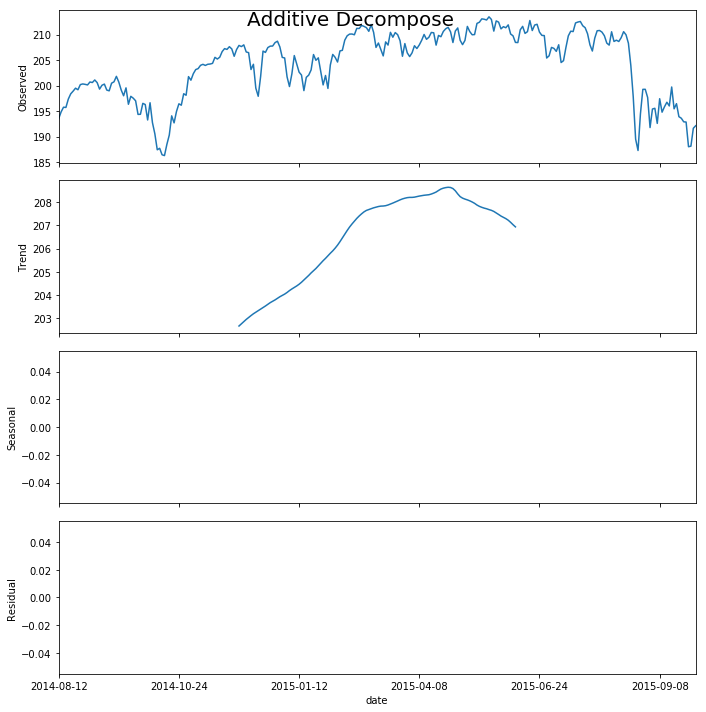

In [47]:
# Frequency
up = 45
down = 30
avg_freq = int((up + down) / 2)
print(avg_freq)

# Multiplicative Decomposition 
result_mul = seasonal_decompose(spy_df, model='multiplicative', freq=150)

# Additive Decomposition
result_add = seasonal_decompose(spy_df, model='additive', freq=150)

# Create plots
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
result_add.plot().suptitle('Additive Decompose', fontsize=20)

In [ ]:
# Train / Val split

# Split 50/50 train/val
val_size = int(len(train_sarimax) * 0.5)
train_sarimax_val = train_sarimax[val_size:len(train_sarimax)]
train_sarimax = train_sarimax[0:val_size]

print('Total number of SARIMAX training observations: ', len(train_sarimax))
print('Total number of SARIMAX validation observations: ', len(train_sarimax_val))
print()
print(train_sarimax.columns)
print()

# Create target vectors for both train and val sets
train_sarimax_Y = train_sarimax['spy']
train_sarimax_X = train_sarimax.drop('spy', axis=1)
train_sarimax_val_Y = train_sarimax_val['spy']
train_sarimax_val_X = train_sarimax_val.drop('spy', axis=1)

print('Number of SARIMAX training X observations: ', len(train_sarimax_X))
print('Number of SARIMAX training Y value observations: ', len(train_sarimax_Y))
print('Number of SARIMAX validation X value observations: ', len(train_sarimax_val_X))
print('Number of SARIMAX validation Y value observations: ', len(train_sarimax_val_Y))

#### Now that the training and validation splits have been made, we can build our SARIMAX model. SARIMAX stands for Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors, and it is a model that can help to understand and predict time series data. These models are typically denoted: SARIMAX(p, d, q). The p is the autoregressive portion of the model. It incorporates the effect of past values on the response variable. The is the integrated portion, and it denotes the amount of differencing which is subtracting past values from the current value. Finally, q represents the moving average portion of the model, and it sets the error of the model as a linear combination of the error values of past observations. Choosing values for p, q, and d can be difficult. Below is an approach called Hyperparameter Optimization, or more simply, Grid Search which iterates through all possible combinations of parameter values within a user-defined range of values. The result of running the model with these different parameters can be evaluated, and a preferred model specification can be chosen.

In [ ]:
# Grid search

# Define range of values for p, d, and q values
p = d = q = range(7, 10)

# Generate list of all combinations of p, d, and q
pdq = list(itertools.product(p, d, q))

# Generate combinations of seasonal p, seasonal d, and seasonal q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Parameter combinations for SARIMAX:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
# SARIMAX

# Time to run
#%%time

# Suppress warnings
warnings.filterwarnings("ignore")

print('Below are the AIC results for each combination: ')

# Loop through pdq and seasonal_pdq combinations and run model for each
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_sarimax_Y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Below are the AIC results for each combination: 


In [541]:
# SARIMAX validation

# Run model on validation data
mod = sm.tsa.statespace.SARIMAX(train_sarimax_val_Y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3707      0.312      1.189      0.234      -0.240       0.981
ma.L1         -0.4911      0.305     -1.610      0.107      -1.089       0.107
ar.S.L12       0.0003      0.007      0.045      0.964      -0.013       0.014
ma.S.L12      -1.0000    498.370     -0.002      0.998    -977.786     975.786
sigma2         3.7342   1861.132      0.002      0.998   -3644.018    3651.486


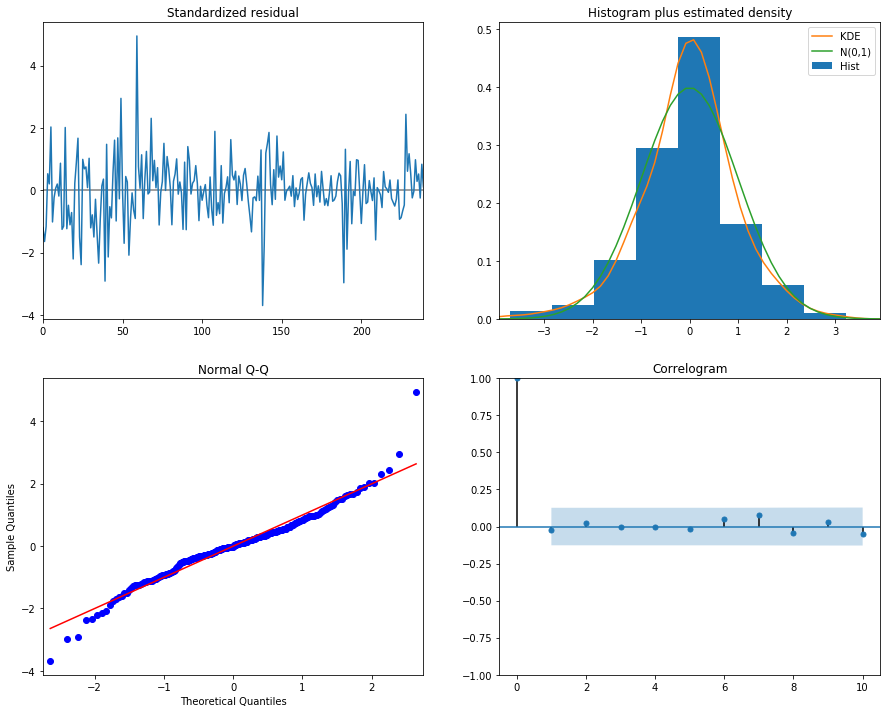

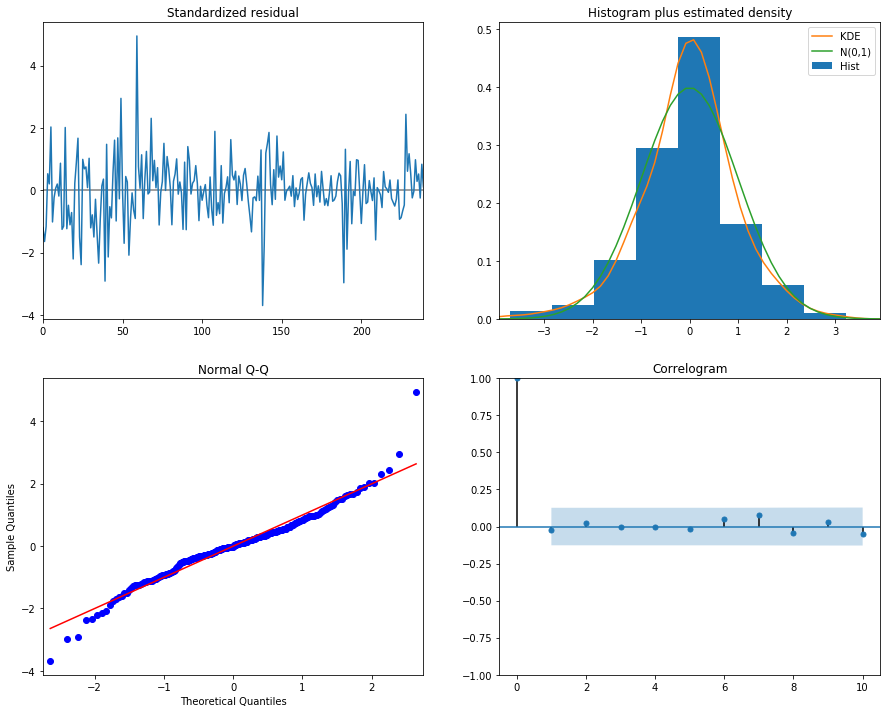

In [542]:
results.plot_diagnostics(figsize=(15, 12))


In [ ]:
# Check for normality using Kolmogorov-Smirnov

In [ ]:
# Goldfeld-Quandt Test